# Mellinguer complete

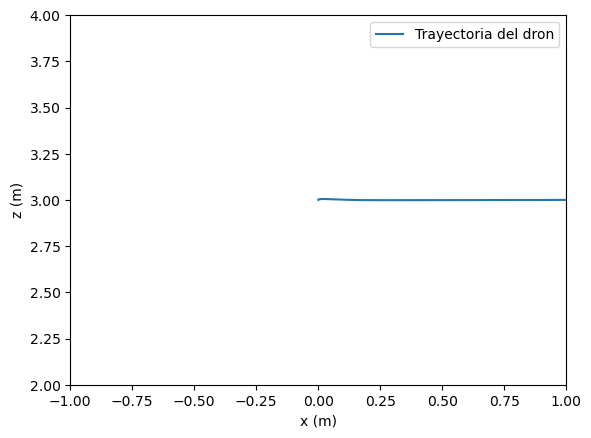

In [19]:
import numpy as np
import mujoco
from mujoco import viewer
import time
from mellinguer_diy import MellinguerController


def quat_to_rotmat(q):
    """Quaternion (w,x,y,z) -> matriz de rotación 3x3."""
    w, x, y, z = q
    return np.array([
        [1 - 2*(y*y + z*z),     2*(x*y - z*w),     2*(x*z + y*w)],
        [    2*(x*y + z*w), 1 - 2*(x*x + z*z),     2*(y*z - x*w)],
        [    2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)


# --- XML con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/single_quadrotor_u1234.xml"  # <-- pon aquí tu nuevo XML

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Body del dron
drone_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "core")
if drone_id < 0:
    raise ValueError("No existe el body 'core' en el XML.")

# Masa total del dron
m = float(model.body_subtreemass[drone_id])

# Posición inicial para hover
mujoco.mj_forward(model, data)
p0 = data.xpos[drone_id].copy()

# Gains como lista: [Kp_pos, Kv_pos, KR_att, Komega_att]
gains = [
    np.array([5.0, 5.0, 10.0]),         # Kp posición (diag)
    np.array([3.0, 3.0, 6.0]),          # Kv velocidad (diag)
    np.array([8.0, 8.0, 2.0]),    # KR actitud (diag)
    np.array([0.2, 0.2, 0.1])         # Komega velocidad angular (diag)
]

controller = MellinguerController(mass=m, gravity=9.81, gains=gains)

# (Opcional) si quieres asignar por nombre para evitar depender del orden:
act_u1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u1_thrust")
act_u2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u2_tau_x")
act_u3 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u3_tau_y")
act_u4 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u4_tau_z")
if min(act_u1, act_u2, act_u3, act_u4) < 0:
    raise ValueError("No encontré actuadores u1_thrust/u2_tau_x/u3_tau_y/u4_tau_z. Revisa el XML.")

# guardar para debug/visualización
vector_r = []
vector_rT = []

with viewer.launch_passive(model, data) as vis:
    t = 0.0

    while vis.is_running():
        # ---------------------------
        # (1) Leer estado en MuJoCo
        # ---------------------------
        r = data.xpos[drone_id].copy()
        q = data.xquat[drone_id].copy()
        R = quat_to_rotmat(q)

        # guardar para debug/visualización
        vector_r.append(r)
        vector_rT.append(rT)

        # cvel = [wx, wy, wz, vx, vy, vz] (world-aligned)
        cvel = data.cvel[drone_id].copy()
        omega_world = cvel[0:3]
        vel_world = cvel[3:6]

        # Tu controlador típicamente usa omega en body
        omega_body = R.T @ omega_world

        # ---------------------------
        # (2) Referencia deseada (ejemplo: oscilación en x)
        # ---------------------------
        x_d = 1 #0.5 * np.sin(0.5 * t)
        x_dot_d = 0 #0.25 * np.cos(0.5 * t)
        x_ddot_d = 0 #-0.125 * np.sin(0.5 * t)

        rT = np.array([p0[0] + x_d, p0[1], p0[2]])
        vT = np.array([x_dot_d, 0.0, 0.0])
        aT = np.array([x_ddot_d, 0.0, 0.0])

        yaw_d = 0.0

        # ---------------------------
        # (3) Control Mellinger -> u = [u1,u2,u3,u4]
        # ---------------------------
        u = controller.step(rT, vT, aT, r, vel_world, R, omega_body, yaw_d)

        # ---------------------------
        # (4) Aplicar controles directo a actuadores
        # ---------------------------
        data.ctrl[act_u1] = u[0]
        data.ctrl[act_u2] = u[1]
        data.ctrl[act_u3] = u[2]
        data.ctrl[act_u4] = u[3]

        # ---------------------------
        # (5) Paso de simulación
        # ---------------------------
        start = time.time()

        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # sincronizar en tiempo real
        elapsed = time.time() - start
        sleep_time = dt - elapsed
        if sleep_time > 0:
            time.sleep(sleep_time)

# visualización de trayectoria (opcional)
import matplotlib.pyplot as plt
vector_r = np.array(vector_r)
plt.figure()
plt.plot(vector_r[:,0], vector_r[:,2], label='Trayectoria del dron')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

#ajustar límites y agregar referencia deseada
plt.xlim(p0[0] - 1, p0[0] + 1)
plt.ylim(p0[2] - 1, p0[2] + 1)

plt.legend()
plt.show()


# Mellinguer modified

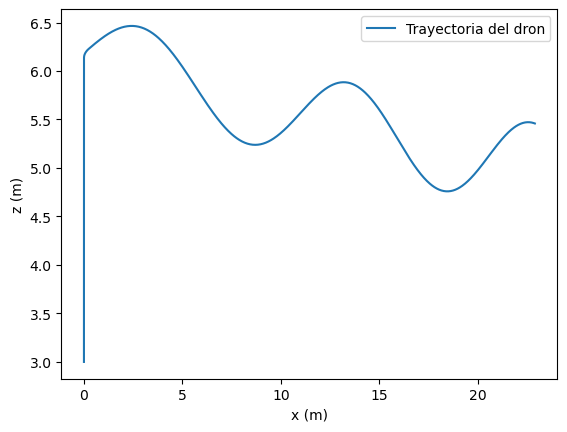

In [24]:
import numpy as np
import mujoco
from mujoco import viewer
import time
from mellinguer_diy import MellinguerControllerModified


def quat_to_rotmat(q):
    """Quaternion (w,x,y,z) -> matriz de rotación 3x3."""
    w, x, y, z = q
    return np.array([
        [1 - 2*(y*y + z*z),     2*(x*y - z*w),     2*(x*z + y*w)],
        [    2*(x*y + z*w), 1 - 2*(x*x + z*z),     2*(y*z - x*w)],
        [    2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)


# --- XML con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/single_quadrotor_u1234.xml"  # <-- pon aquí tu nuevo XML

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Body del dron
drone_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "core")
if drone_id < 0:
    raise ValueError("No existe el body 'core' en el XML.")

# Masa total del dron
m = float(model.body_subtreemass[drone_id])

# Posición inicial para hover
mujoco.mj_forward(model, data)
p0 = data.xpos[drone_id].copy()

# Gains como lista: [Kp_pos, Kv_pos, KR_att, Komega_att]
gains = [
    np.array([5.0, 5.0, 10.0]),         # Kp posición (diag)
    np.array([3.0, 3.0, 6.0]),          # Kv velocidad (diag)
    np.array([8.0, 8.0, 2.0]),    # KR actitud (diag)
    np.array([0.2, 0.2, 0.1])         # Komega velocidad angular (diag)
]

controller = MellinguerControllerModified(mass=m, gravity=9.81, gains=gains)

# (Opcional) si quieres asignar por nombre para evitar depender del orden:
act_u1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u1_thrust")
act_u2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u2_tau_x")
act_u3 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u3_tau_y")
act_u4 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u4_tau_z")
if min(act_u1, act_u2, act_u3, act_u4) < 0:
    raise ValueError("No encontré actuadores u1_thrust/u2_tau_x/u3_tau_y/u4_tau_z. Revisa el XML.")

# guardar para debug/visualización
vector_r = []
vector_rT = []

with viewer.launch_passive(model, data) as vis:
    t = 0.0

    while vis.is_running():
        # ---------------------------
        # (1) Leer estado en MuJoCo
        # ---------------------------
        r = data.xpos[drone_id].copy()
        q = data.xquat[drone_id].copy()
        R = quat_to_rotmat(q)

        # guardar para debug/visualización
        vector_r.append(r)
        # vector_rT.append(rT)

        # cvel = [wx, wy, wz, vx, vy, vz] (world-aligned)
        cvel = data.cvel[drone_id].copy()
        omega_world = cvel[0:3]
        vel_world = cvel[3:6]

        # Tu controlador típicamente usa omega en body
        omega_body = R.T @ omega_world

        # ---------------------------
        # (2) Referencia deseada (ejemplo: oscilación en x)
        # ---------------------------
        x_d = 1 #0.5 * np.sin(0.5 * t)
        x_dot_d = 0 #0.25 * np.cos(0.5 * t)
        x_ddot_d = 0 #-0.125 * np.sin(0.5 * t)

        rT = np.array([p0[0] + x_d, p0[1], p0[2]])
        vT = np.array([x_dot_d, 0.0, 0.0])
        aT = np.array([x_ddot_d, 0.0, 0.0])

        yaw_d = 0.0

        # funcion seno
        F_des = np.array([0.0, 0.0, m*9.81 + 0.5 * np.sin(2 * t)])  # Solo queremos hover, fuerza hacia arriba igual al peso

        # F_des = np.array([0.0, 0.0, m*9.81 + np.sin()])  # Solo queremos hover, fuerza hacia arriba igual al peso

        # ---------------------------
        # (3) Control Mellinger -> u = [u1,u2,u3,u4]
        # ---------------------------
        u = controller.step(F_des, R, omega_body, yaw_d)

        # ---------------------------
        # (4) Aplicar controles directo a actuadores
        # ---------------------------
        data.ctrl[act_u1] = u[0]
        data.ctrl[act_u2] = u[1]
        data.ctrl[act_u3] = u[2]
        data.ctrl[act_u4] = u[3]

        # ---------------------------
        # (5) Paso de simulación
        # ---------------------------
        start = time.time()

        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # sincronizar en tiempo real
        elapsed = time.time() - start
        sleep_time = dt - elapsed
        if sleep_time > 0:
            time.sleep(sleep_time)

# visualización de trayectoria (opcional)
import matplotlib.pyplot as plt
vector_r = np.array(vector_r)
plt.figure()
plt.plot(vector_r[:,0], vector_r[:,2], label='Trayectoria del dron')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
#ajustar límites y agregar referencia deseada
# plt.xlim(p0[0] - 1, p0[0] + 1)
# plt.ylim(p0[2] - 1, p0[2] + 1)
plt.legend()
plt.show()


# Mellinguer two drones

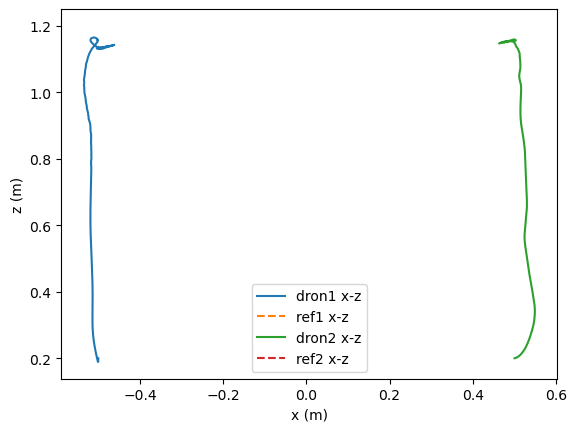

In [30]:
import numpy as np
import mujoco
from mujoco import viewer
import time
from mellinguer_diy import MellinguerController


def quat_to_rotmat(q):
    w, x, y, z = q
    return np.array([
        [1 - 2*(y*y + z*z),     2*(x*y - z*w),     2*(x*z + y*w)],
        [    2*(x*y + z*w), 1 - 2*(x*x + z*z),     2*(y*z - x*w)],
        [    2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)


# --- XML 2 drones con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/quadrotors_with_flexrod_u1234.xml"   # <-- cambia al nombre real

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# IDs de cuerpos
id_core1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "core_1")
id_core2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "core_2")
if id_core1 < 0 or id_core2 < 0:
    raise ValueError("No encontré core_1 / core_2 en el XML.")

# Masa total por dron (subtree)
m1 = float(model.body_subtreemass[id_core1])
m2 = float(model.body_subtreemass[id_core2])

# Forward una vez
mujoco.mj_forward(model, data)
p01 = data.xpos[id_core1].copy()
p02 = data.xpos[id_core2].copy()

# Gains (una sola instancia por dron; puedes usar mismos gains o distintos)
gains = [
    np.array([5.0, 5.0, 10.0]),     # Kp
    np.array([3.0, 3.0, 6.0]),      # Kv
    np.array([8.0, 8.0, 2.0]),    # KR (bajitas para evitar vibración)
    np.array([0.2, 0.2, 0.1])       # Komega
]

ctrl1 = MellinguerController(mass=m1, gravity=9.81, gains=gains)
ctrl2 = MellinguerController(mass=m2, gravity=9.81, gains=gains)

# IDs de actuadores (por nombre)
def act_id(name: str) -> int:
    aid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name)
    if aid < 0:
        raise ValueError(f"No encontré el actuator '{name}'. Revisa el XML.")
    return aid

u1_1 = act_id("u1_thrust_1")
u2_1 = act_id("u2_tau_x_1")
u3_1 = act_id("u3_tau_y_1")
u4_1 = act_id("u4_tau_z_1")

u1_2 = act_id("u1_thrust_2")
u2_2 = act_id("u2_tau_x_2")
u3_2 = act_id("u3_tau_y_2")
u4_2 = act_id("u4_tau_z_2")

# Debug
traj1, traj1_ref = [], []
traj2, traj2_ref = [], []

with viewer.launch_passive(model, data) as vis:
    t = 0.0

    while vis.is_running():
        # =========================
        # Estado dron 1
        # =========================
        r1 = data.xpos[id_core1].copy()
        q1 = data.xquat[id_core1].copy()
        R1 = quat_to_rotmat(q1)

        cvel1 = data.cvel[id_core1].copy()  # [w, v] world-aligned
        omega1_world = cvel1[0:3]
        v1_world = cvel1[3:6]
        omega1_body = R1.T @ omega1_world

        # =========================
        # Estado dron 2
        # =========================
        r2 = data.xpos[id_core2].copy()
        q2 = data.xquat[id_core2].copy()
        R2 = quat_to_rotmat(q2)

        cvel2 = data.cvel[id_core2].copy()
        omega2_world = cvel2[0:3]
        v2_world = cvel2[3:6]
        omega2_body = R2.T @ omega2_world

        # =========================
        # Referencias (ejemplo simple)
        # - dron 1 va a x = p01[0] + 1
        # - dron 2 va a x = p02[0] - 1
        # =========================
        x_d = 0.0
        x_dot_d = 0.0
        x_ddot_d = 0.0

        rT1 = np.array([p01[0] + x_d, p01[1], p01[2]+1])
        vT1 = np.array([x_dot_d, 0.0, 0.0])
        aT1 = np.array([x_ddot_d, 0.0, 0.0])
        yaw1 = 0.0

        rT2 = np.array([p02[0] - x_d, p02[1], p02[2]+1])
        vT2 = np.array([x_dot_d, 0.0, 0.0])
        aT2 = np.array([x_ddot_d, 0.0, 0.0])
        yaw2 = 0.0

        # =========================
        # Control -> u=[u1,u2,u3,u4] por dron
        # =========================
        u_1 = ctrl1.step(rT1, vT1, aT1, r1, v1_world, R1, omega1_body, yaw1)
        u_2 = ctrl2.step(rT2, vT2, aT2, r2, v2_world, R2, omega2_body, yaw2)

        # =========================
        # Aplicar controles directos
        # =========================
        data.ctrl[u1_1] = u_1[0]
        data.ctrl[u2_1] = u_1[1]
        data.ctrl[u3_1] = u_1[2]
        data.ctrl[u4_1] = u_1[3]

        data.ctrl[u1_2] = u_2[0]
        data.ctrl[u2_2] = u_2[1]
        data.ctrl[u3_2] = u_2[2]
        data.ctrl[u4_2] = u_2[3]

        # Debug
        traj1.append(r1); traj1_ref.append(rT1)
        traj2.append(r2); traj2_ref.append(rT2)

        # =========================
        # Step MuJoCo
        # =========================
        start = time.time()
        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # tiempo real (opcional)
        elapsed = time.time() - start
        if dt - elapsed > 0:
            time.sleep(dt - elapsed)


# Plot rápido (opcional)
import matplotlib.pyplot as plt
traj1 = np.array(traj1); traj1_ref = np.array(traj1_ref)
traj2 = np.array(traj2); traj2_ref = np.array(traj2_ref)

plt.figure()
plt.plot(traj1[:,0], traj1[:,2], label="dron1 x-z")
plt.plot(traj1_ref[:,0], traj1_ref[:,2], "--", label="ref1 x-z")
plt.plot(traj2[:,0], traj2[:,2], label="dron2 x-z")
plt.plot(traj2_ref[:,0], traj2_ref[:,2], "--", label="ref2 x-z")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.legend()
plt.show()


# With MPPI planner

In [ ]:
import numpy as np
import mujoco
from mujoco import viewer
import time
from mellinguer_diy import MellinguerController
from MPPI import MPPIPlanner


def quat_to_rotmat(q):
    """Quaternion (w,x,y,z) -> matriz de rotación 3x3."""
    w, x, y, z = q
    return np.array([
        [1 - 2*(y*y + z*z),     2*(x*y - z*w),     2*(x*z + y*w)],
        [    2*(x*y + z*w), 1 - 2*(x*x + z*z),     2*(y*z - x*w)],
        [    2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)


# --- XML con actuadores directos u1,u2,u3,u4 ---
XML_PATH = "system/single_quadrotor_u1234.xml"  # <-- pon aquí tu nuevo XML

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Body del dron
drone_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "core")
if drone_id < 0:
    raise ValueError("No existe el body 'core' en el XML.")

# Masa total del dron
m = float(model.body_subtreemass[drone_id])

# Posición inicial para hover
mujoco.mj_forward(model, data)
p0 = data.xpos[drone_id].copy()

# Gains como lista: [Kp_pos, Kv_pos, KR_att, Komega_att]
gains = [
    np.array([5.0, 5.0, 10.0]),         # Kp posición (diag)
    np.array([3.0, 3.0, 6.0]),          # Kv velocidad (diag)
    np.array([8.0, 8.0, 2.0]),    # KR actitud (diag)
    np.array([0.2, 0.2, 0.1])         # Komega velocidad angular (diag)
]

controller = MellinguerController(mass=m, gravity=9.81, gains=gains)

# (Opcional) si quieres asignar por nombre para evitar depender del orden:
act_u1 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u1_thrust")
act_u2 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u2_tau_x")
act_u3 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u3_tau_y")
act_u4 = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "u4_tau_z")
if min(act_u1, act_u2, act_u3, act_u4) < 0:
    raise ValueError("No encontré actuadores u1_thrust/u2_tau_x/u3_tau_y/u4_tau_z. Revisa el XML.")

# guardar para debug/visualización
vector_r = []
vector_rT = []

with viewer.launch_passive(model, data) as vis:
    t = 0.0

    while vis.is_running():
        # ---------------------------
        # (1) Leer estado en MuJoCo
        # ---------------------------
        r = data.xpos[drone_id].copy()
        q = data.xquat[drone_id].copy()
        R = quat_to_rotmat(q)

        # guardar para debug/visualización
        vector_r.append(r)
        vector_rT.append(rT)

        # cvel = [wx, wy, wz, vx, vy, vz] (world-aligned)
        cvel = data.cvel[drone_id].copy()
        omega_world = cvel[0:3]
        vel_world = cvel[3:6]

        # Tu controlador típicamente usa omega en body
        omega_body = R.T @ omega_world

        # ---------------------------
        # (2) Referencia deseada (ejemplo: oscilación en x)
        # ---------------------------
        x_d = 1 #0.5 * np.sin(0.5 * t)
        x_dot_d = 0 #0.25 * np.cos(0.5 * t)
        x_ddot_d = 0 #-0.125 * np.sin(0.5 * t)

        rT = np.array([p0[0] + x_d, p0[1], p0[2]])
        vT = np.array([x_dot_d, 0.0, 0.0])
        aT = np.array([x_ddot_d, 0.0, 0.0])

        yaw_d = 0.0

        # ---------------------------
        # (3) Control Mellinger -> u = [u1,u2,u3,u4]
        # ---------------------------
        u = controller.step(rT, vT, aT, r, vel_world, R, omega_body, yaw_d)

        # ---------------------------
        # (4) Aplicar controles directo a actuadores
        # ---------------------------
        data.ctrl[act_u1] = u[0]
        data.ctrl[act_u2] = u[1]
        data.ctrl[act_u3] = u[2]
        data.ctrl[act_u4] = u[3]

        # ---------------------------
        # (5) Paso de simulación
        # ---------------------------
        start = time.time()

        mujoco.mj_step(model, data)
        vis.sync()
        t += dt

        # sincronizar en tiempo real
        elapsed = time.time() - start
        sleep_time = dt - elapsed
        if sleep_time > 0:
            time.sleep(sleep_time)

# visualización de trayectoria (opcional)
import matplotlib.pyplot as plt
vector_r = np.array(vector_r)
plt.figure()
plt.plot(vector_r[:,0], vector_r[:,2], label='Trayectoria del dron')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

#ajustar límites y agregar referencia deseada
plt.xlim(p0[0] - 1, p0[0] + 1)
plt.ylim(p0[2] - 1, p0[2] + 1)

plt.legend()
plt.show()
